# Local Crystallography Analysis for Lattice Atomic Defects

### Authors: Artem Maksov, Maxim Ziatdinov*

*_Correspondence to: ziatdinovmax@gmail.com_

_Date: 02/28/2018_    

In this notebook, we demonstrate how to study statistically significant deformation of the nearest neighborhood for each extracted defect structure using principal component analysis (PCA)

### Import modules

In [1]:
import os
import h5py
 
import numpy as np
from scipy import ndimage
import cv2

import matplotlib
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import pylab as P

from keras.models import load_model

from scipy.spatial import cKDTree

%matplotlib inline

Using TensorFlow backend.


### Structure of the defects

#### 1. Finding coordinates

We can use a pretrained convolutional neural network model for atomic coordinates identification

In [4]:
atomgen = load_model('AtomGen_small5-8.h5')

In [5]:
totdefim = np.load('defim.npy')

In [6]:
totdefim2 = totdefim[:, :, :].reshape(totdefim.shape[0], totdefim.shape[1], totdefim.shape[2], 1)

In [7]:
totpred = atomgen.predict(totdefim2).reshape(len(totdefim2), 32, 32, 2)

Extracting coordinates of atoms in all the defect structures

In [8]:
def coord_edges(coordinates, dist_edge):
    return [coordinates[0] > target_size[0] - dist_edge, coordinates[0] < dist_edge,
            coordinates[1] > target_size[0] - dist_edge, coordinates[1] < dist_edge]
    
def get_coordinates(input_imgs, decoded_imgs, channel = 0, threshold = 0.75, dist_edge = 0):
    d_list = list()
    for i in range(input_imgs.shape[0]):
        input_img = input_imgs[i,:,:,0]
        decoded_img = decoded_imgs[i,:,:,channel]
        _,thresh = cv2.threshold(decoded_img, threshold, 1, cv2.THRESH_BINARY) 
        labels, nlabels = ndimage.label(thresh)
        coord = np.array(ndimage.center_of_mass(thresh, labels, np.arange(nlabels)+1))
        coord = coord.reshape(coord.shape[0], 2)
       
        coord_to_rem = [idx for idx, c in enumerate(coord) if any(coord_edges(c, dist_edge))]
        coord_to_rem = np.array(coord_to_rem, dtype = int)
        coord = np.delete(coord, coord_to_rem, axis = 0)
             
        d_list.append(coord)
                  
    return d_list

In [9]:
target_size = (32, 32)
atomic_coord = get_coordinates(totdefim2, totpred, channel = 1)

#### 2. Finding structural elements

To be able to compare structure of the images we need to:
    1. Choose fixed origin - in this case it will be the center of extracted image which corresponds to our initial defect coordinate
    2. Choose fixed number of atoms to work with - in this case we are going to look at 7
    3. Find the average positions of atoms we are going to look at.
    4. For each image, find the atomic coordinates corresponding to those.
    
First, let us look at how the code works:

We define center of the image and number of neighbors to look at:

In [10]:
clusters = np.load('clusters.npy')

In [11]:
imcenter = [15.5, 15.5]
nn = 7

We get the average image for a cluster and find the atoms to look at:

In [27]:
numcluster = 1
cl = totdefim[clusters == numcluster]
cla = np.mean(cl, axis=0)
cla2 = cla.reshape(1, cla.shape[0], cla.shape[1], 1)
clapred = atomgen.predict(cla2).reshape(1, cla.shape[0], cla.shape[0], 2)
cla_coord = get_coordinates(cla2, clapred, channel = 1)[0]

T = cKDTree(cla_coord)
d, ix = T.query(imcenter, nn)

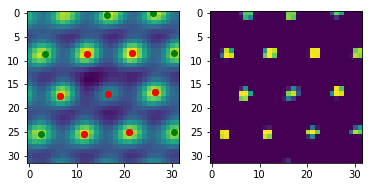

In [28]:
fig441 = plt.figure(441)
ax = fig441.add_subplot(121)
ax.imshow(cla)
ax.scatter(cla_coord[:, 1], cla_coord[:, 0], c='green')
ax.scatter(cla_coord[ix, 1], cla_coord[ix, 0], c='red')
ax = fig441.add_subplot(122)
ax.imshow(clapred[0,:,:,1])

Now, for an example of defect from this class, we can find nearest atoms to those of the average image:

In [14]:
T2 = cKDTree(atomic_coord[0])
d2, ix2 = T2.query(cla_coord[ix], 1)

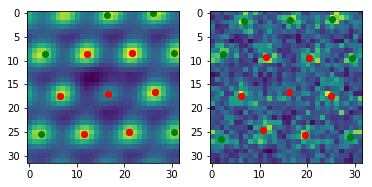

In [15]:
fig442 = plt.figure(442)
ax = fig442.add_subplot(121)
ax.imshow(cla)
ax.scatter(cla_coord[:, 1], cla_coord[:, 0], c='green')
ax.scatter(cla_coord[ix, 1], cla_coord[ix, 0], c='red')
ax = fig442.add_subplot(122)
ax.imshow(totdefim[0])
ax.scatter(atomic_coord[0][:, 1], atomic_coord[0][:, 0], c='green' )
ax.scatter(atomic_coord[0][ix2, 1], atomic_coord[0][ix2, 0], c='red' )

This allows us to create a matrix of positions of the same atoms in each individual example:

In [16]:
ndefs = (clusters == numcluster).sum()
coormat = np.zeros(shape=(ndefs, 14))
defcount = 0
for i in range(len(atomic_coord)):
    if clusters[i] == numcluster:
        T2 = cKDTree(atomic_coord[i])
        d2, ix2 = T2.query(cla_coord[ix], 1)
        coormat[defcount, 0:7] = atomic_coord[i][ix2, 1]
        coormat[defcount, 7:] = atomic_coord[i][ix2, 0]
        defcount += 1

We can compute mean values to ensure that this worked as planned:

In [17]:
meancoor = coormat.mean(axis=0)

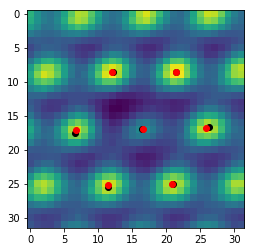

In [18]:
fig443 = plt.figure(443)
ax = fig443.add_subplot(111)
ax.imshow(cla)
ax.scatter(cla_coord[ix, 1], cla_coord[ix, 0], c='black')
for i in range(7):
    ax.scatter(meancoor[i], meancoor[i+7], c='red')

Here, black dots represent coordinates inferred from the average image, and red dots are the average values for coordinates found in all images of this cluster. As we can see, those 2 sets correspond very closely.

Here we will define a function that will do this analysis automatically:

In [19]:
def clustAnalysis(totdefim, clusters, atomic_coord,  atomgen, imcenter, nn, numcluster, thresh=0.5):
    
    
    cl = totdefim[clusters == numcluster]
    cla = np.mean(cl, axis=0)
    cla2 = cla.reshape(1, cla.shape[0], cla.shape[1], 1)
    clapred = atomgen.predict(cla2).reshape(1, cla.shape[0], cla.shape[0], 2)
    cla_coord = get_coordinates(cla2, clapred, channel = 1, threshold=thresh)[0]

    T = cKDTree(cla_coord)
    d, ix = T.query(imcenter, nn)
    
    ndefs = (clusters == numcluster).sum()
    coormat = np.zeros(shape=(ndefs, 14))
    defcount = 0
    for i in range(len(atomic_coord)):
        if clusters[i] == numcluster:
            T2 = cKDTree(atomic_coord[i])
            d2, ix2 = T2.query(cla_coord[ix], 1)
            coormat[defcount, 0:7] = atomic_coord[i][ix2, 1]
            coormat[defcount, 7:] = atomic_coord[i][ix2, 0]
            defcount += 1
            
    return cla, cla_coord[ix], coormat

#### 3. PCA on structures

We can perfrom PCA on resulting matrices for each cluster to identify most important variations in those coordinates

In [20]:
cla, cla_coord, coormat = clustAnalysis(totdefim, clusters, atomic_coord,  atomgen, imcenter, nn, 1, 0.5)

For each sample, we subtract center of mass of all atoms from each individual atoms

In [21]:
coormat2 = np.zeros_like(coormat)
for i, coor in enumerate(coormat):
    coormat2[i, 0:7] = coor[0:7] - coor[0:7].mean()
    coormat2[i, 7:] = coor[7:] - coor[7:].mean()

We use SVD to compute eigenvectors. The first one shows average positions, and later ones show directions of significant variance.

In [22]:
U, s, V = np.linalg.svd(coormat2, full_matrices=False)
e_vec = s*V.T

In [23]:
colors = ['red', 'blue', 'green', 'black', 'magenta', 'cyan', 'darkviolet', 'darkorange', 'gold', 'pink']

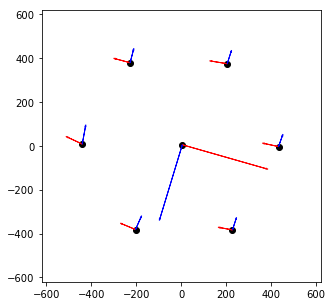

In [24]:
# number of PCA components to display
n_comp = 2
fig444 = plt.figure(444, figsize=(5, 5))
ax = fig444.add_subplot(111)
ax.axis([-620, 620, - 620, 620])
scale = 5
for i in range(7):
    ax.scatter(e_vec[i, 0], e_vec[i+7, 0], c='k')
        
    for i2 in range(n_comp):
        P.arrow(e_vec[i, 0], e_vec[i + 7, 0], 
            scale * (e_vec[i, i2 + 1]), scale *( e_vec[i+7, i2 + 1]), 
            head_width=5, head_length=10, ec=colors[i2])